In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, SpectralBiclustering
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import tqdm

In [94]:
# hr_data = pd.read_csv('data/HR_data.csv')
hr_data = pd.read_csv('Data/HR_data_2.csv')
# print(hr_data.columns)

In [95]:
# Helper functions 
def gap_statistic(range_n_clusters, numpy_data):
    def wk(labels, data, k):
        clusters = {i: data[labels == i] for i in range(k)}
        centroids = np.array([np.mean(clusters[i], axis=0) for i in range(k)])
        w_k = 0
        for l in range(k):
            cluster = clusters[l]
            N_l = cluster.shape[0]
            if N_l == 0: continue
            dist = np.linalg.norm(cluster - centroids[l], axis=1)
            D_l = N_l * np.sum(dist**2)
            w_k += D_l / (2 * N_l)
        return w_k

    sim_data_sets = [np.random.uniform(np.min(numpy_data, axis=0), 
                                       np.max(numpy_data, axis=0), 
                                       size=numpy_data.shape) 
                     for _ in range(20)]  

    w_ks, u_ks = [], []
    for k in tqdm.tqdm(range_n_clusters):
        labels = KMeans(n_clusters=k).fit_predict(numpy_data) # TODO: Set random_state?
        w_ks.append(wk(labels, numpy_data, k))

        sim_wks = []
        for sim in sim_data_sets:
            sim_labels = KMeans(n_clusters=k).fit_predict(sim) # TODO: Set random_state?
            sim_wks.append(wk(sim_labels, sim, k))
        u_ks.append(sim_wks)  
    u_ks = np.array(u_ks)
    w_ks = np.array(w_ks)  # Convert to numpy array

    g_k = np.log(u_ks.mean(axis=1)) - np.log(w_ks)  # Compute gap statistic
    return g_k, u_ks, w_ks  # Return w_ks as well

In [96]:
"""
NOTE: D11 winter, and D12 and D13 were completed in the fall 
D131 and D133 were completed in the morning and D132 and D134 were collected in the evening
"Frustrated" is (Only asked in the task phase) On a scale from 0-10, where 0 is not difficult at all and 10 is extremely difficult, how difficult did you find the task?
there are 312 rows = 26 participants * 4 rounds * 3 phases
"""

# Special columns:
# Round,Phase,Individual,Puzzler,original_ID,raw_data_path,Team_ID,Frustrated,Cohort,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined
# Categorical/Ordinal categorical columns: Round,Phase,Individual,Puzzler,original_ID,raw_data_path,Team_ID,Cohort,frustrated,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined

# Find missing values
print("There are na values in the data: ", hr_data.isna().sum().sum())
print("The missing values are in the following columns: ", hr_data.isna().sum()[hr_data.isna().sum() > 0].index.tolist())
print("The missing values are in the following rows: ", hr_data[hr_data.isna().sum(axis=1) > 0].index.tolist())

# Replace the missing values with the mode of the column
for col in hr_data.columns:
    if hr_data[col].isna().sum() > 0:
        if hr_data[col].dtype == 'object' or hr_data[col].dtype.name == 'category':
            hr_data[col] = hr_data[col].fillna(hr_data[col].mode()[0])
        else:
            hr_data[col] = hr_data[col].fillna(int(hr_data[col].mode()[0]))

# One hot encoding for the string columns
hr_data_with_dummies = pd.get_dummies(hr_data, columns=['Cohort', 'Round', 'Phase', 'Team_ID', 'Puzzler'], dtype=np.int8)
# hr_data_with_dummies.info()

# Keep all columns except the first column (participant ID) the raw data path column
hr_data_with_dummies = hr_data_with_dummies.drop('raw_data_path', axis=1)
hr_data_with_dummies = hr_data_with_dummies.iloc[:, 1:]
# hr_data_with_dummies.info()

# Check missing values
print("After there are na values in the data: ", hr_data.isna().sum().sum())
print("After the missing values are in the following columns: ", hr_data.isna().sum()[hr_data.isna().sum() > 0].index.tolist())
print("After the missing values are in the following rows: ", hr_data[hr_data.isna().sum(axis=1) > 0].index.tolist())

numpy_data = hr_data_with_dummies.to_numpy()




There are na values in the data:  9
The missing values are in the following columns:  ['EDA_TD_P_RT', 'EDA_TD_P_ReT', 'inspired', 'attentive', 'afraid', 'active', 'determined']
The missing values are in the following rows:  [104, 120, 122, 125, 272]
After there are na values in the data:  0
After the missing values are in the following columns:  []
After the missing values are in the following rows:  []


100%|██████████| 59/59 [00:00<00:00, 73.45it/s]


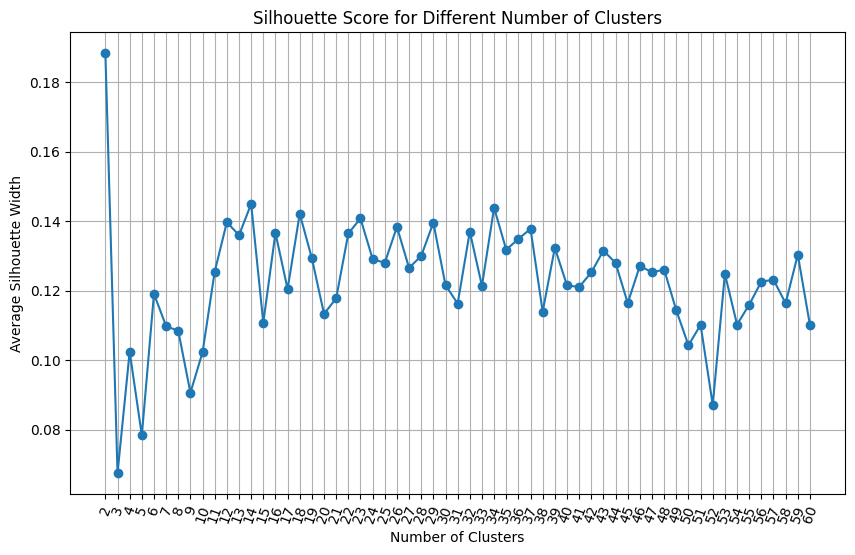

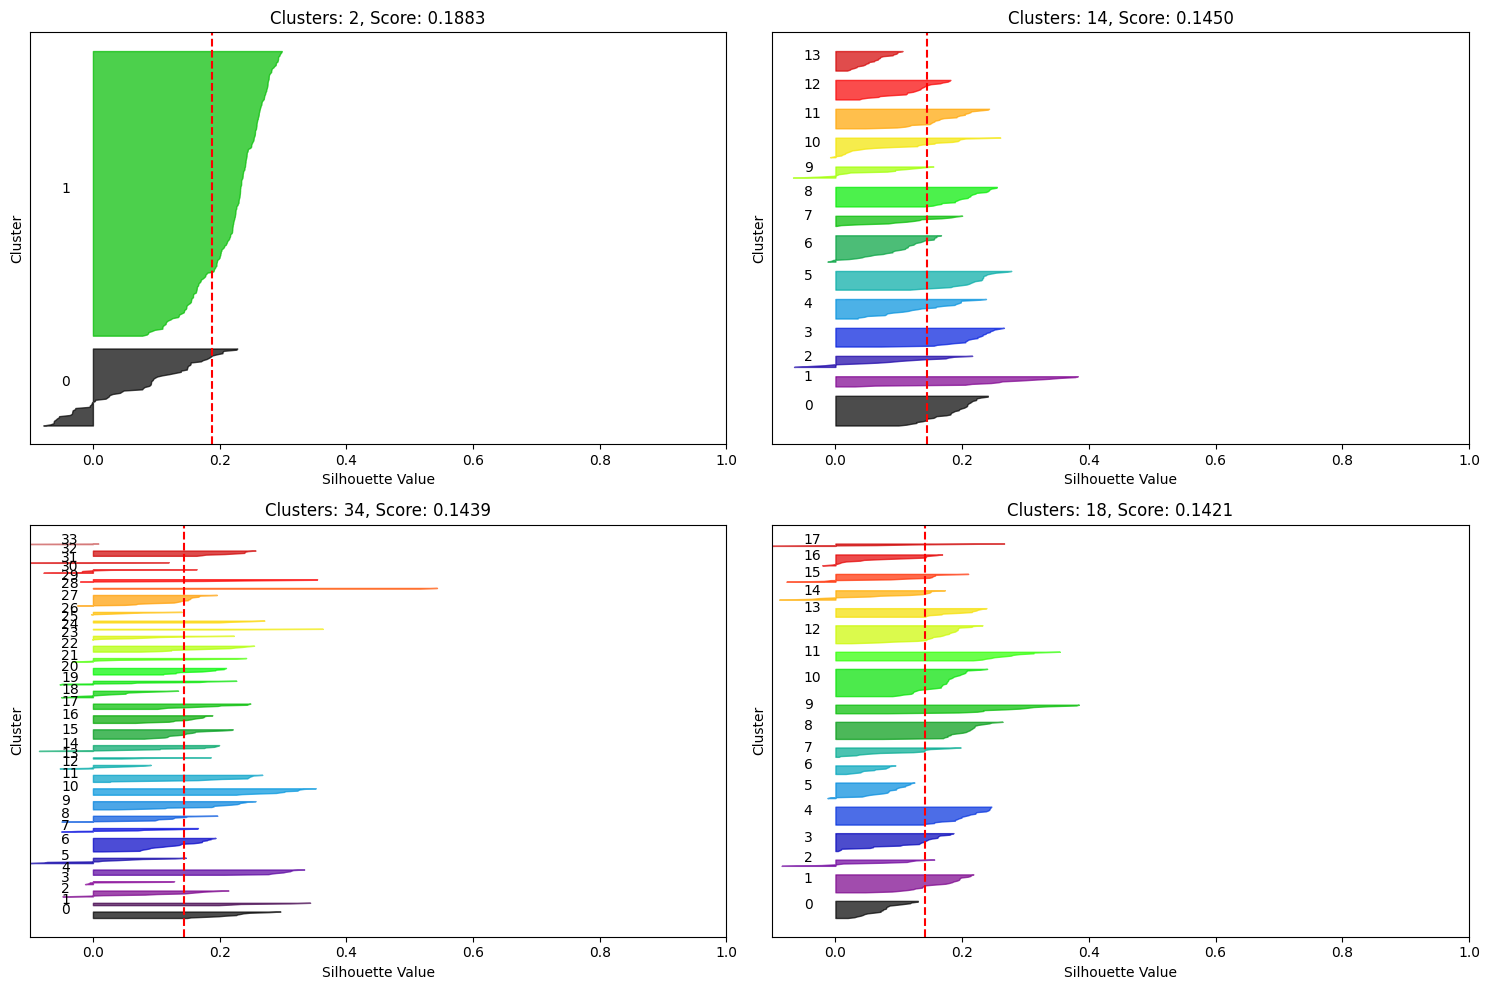

Choice 1, using the maximum average silhouette: 2 with a value of 0.18829497720609845
Choice 2, using the rule that all clusters have average s(i) > overall average:  2


In [97]:
# Normalize the data
numpy_data = StandardScaler().fit_transform(numpy_data)

#### Silhouette analysis ####
cluster_range = range(2, 61)
results = []
s_scores = []
for n_clusters in tqdm.tqdm(cluster_range):
    clusterer = KMeans(n_clusters=n_clusters) # TODO: do we need to set the random state?
    cluster_labels = clusterer.fit_predict(numpy_data)
    silhouette_avg = silhouette_score(numpy_data, cluster_labels)
    silhouette_vals = silhouette_samples(numpy_data, cluster_labels)
    
    # Store results
    results.append({
        'n_clusters': n_clusters,
        'score': silhouette_avg,
        'labels': cluster_labels,
        'silhouette_vals': silhouette_vals,
        'clusterer': clusterer  # Optional: store the model if needed later
    })
    s_scores.append(silhouette_avg)


# Plot 1: Silhouette score vs number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, s_scores, marker='o')
plt.xticks(cluster_range, rotation=70)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Width')
plt.title('Silhouette Score for Different Number of Clusters')
plt.grid(True)
plt.show()


# Find the top 4 cluster configurations
top_indices = sorted(range(len(s_scores)), key=lambda i: s_scores[i], reverse=True)[:4]
top_clusters = [results[i] for i in top_indices]

# Plot 2: Silhouette plots for top 4 configurations
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for i, result in enumerate(top_clusters):
    ax = axs[i]

    n_clusters = result['n_clusters']
    score = result['score']
    cluster_labels = result['labels']
    silhouette_vals = result['silhouette_vals']
    
    y_lower = 10
    for cluster in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == cluster]
        cluster_silhouette_vals.sort()
        
        size_cluster = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster
        
        color = plt.cm.nipy_spectral(float(cluster) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                        facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with cluster numbers
        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
        
        # Update y_lower for next plot
        y_lower = y_upper + 10
        
    # The vertical line for average silhouette score
    ax.axvline(x=score, color="red", linestyle="--")
    ax.set_title(f'Clusters: {n_clusters}, Score: {score:.4f}')
    ax.set_xlabel("Silhouette Value")
    ax.set_ylabel("Cluster")
    ax.set_yticks([])  # Clear the y-axis labels / ticks
    ax.set_xlim([-0.1, 1])

plt.tight_layout()
plt.show()

# Choose K∗ with the maximum average silhouette
best_idx = s_scores.index(max(s_scores))
print(f"Choice 1, using the maximum average silhouette: {cluster_range[best_idx]} with a value of {max(s_scores)}")

# Choose the smallest K such that all clusters have average s(i) > overall average
mean_silhouette = np.mean(s_scores)
print("Choice 2, using the rule that all clusters have average s(i) > overall average: ", 
      cluster_range[next(i for i, score in enumerate(s_scores) if score > mean_silhouette)])

  2%|▏         | 1/59 [00:00<00:10,  5.75it/s]

100%|██████████| 59/59 [00:10<00:00,  5.66it/s]

Choice 3, using the gap statistic: 10


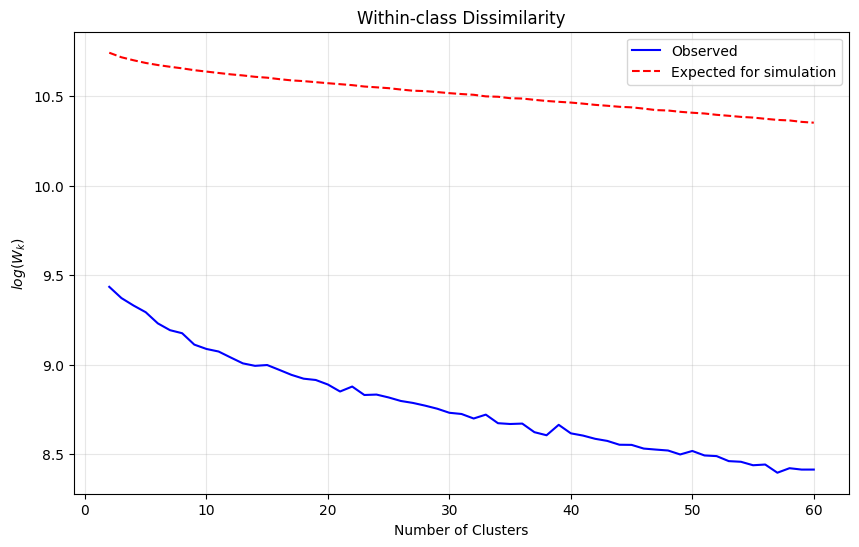

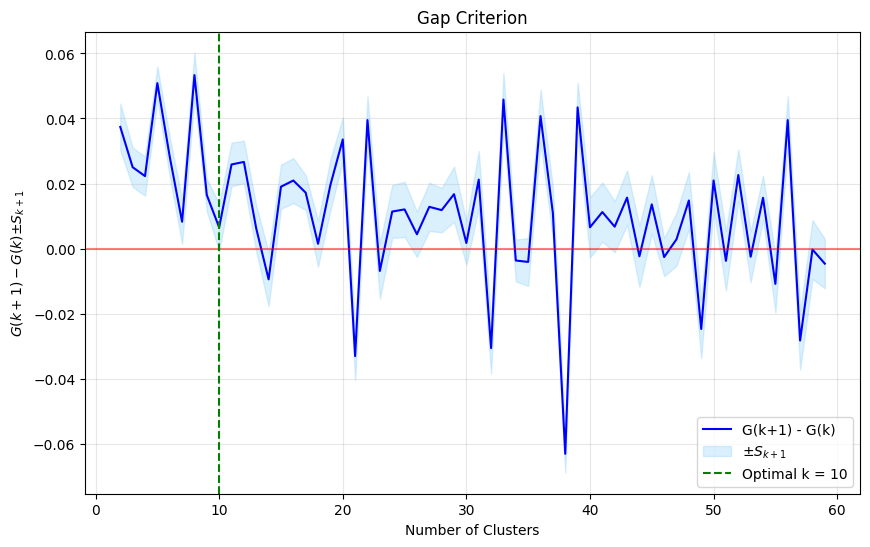

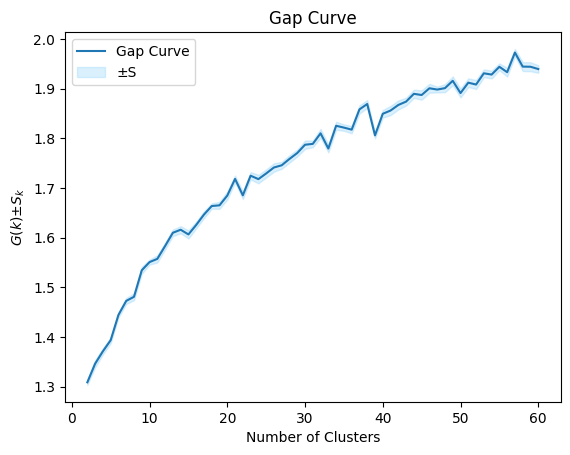

In [98]:
#### Gap statistic ####
g, u, w_ks = gap_statistic(cluster_range, numpy_data)

s = np.std(np.log(u), axis=1) * np.sqrt(1 + 1 / 20)

# Calculate best_k according to the Gap Statistic criterion
best_k = None
for i in range(len(g)-1):
    if g[i] >= g[i+1] - s[i+1]:
        best_k = cluster_range[i]
        break
if best_k is None:
    best_k = cluster_range[-1]  # Default to the largest k if no earlier optimum found
print(f"Choice 3, using the gap statistic: {best_k}")


# Plot 1: Within-class dissimilarity
plt.figure(figsize=(10, 6))
plt.title("Within-class Dissimilarity")
# Plot observed log(W)
plt.plot(cluster_range, np.log(w_ks), 'b-', label='Observed')
# Calculate and plot expected log(W) from reference distribution
Elog_Wu = np.log(u.mean(axis=1))
plt.plot(cluster_range, Elog_Wu, 'r--', label='Expected for simulation')
plt.legend(loc='upper right')
plt.xlabel("Number of Clusters")
plt.ylabel(r"$log(W_k)$")
plt.grid(True, alpha=0.3)
plt.show()


# Plot 2: Gap differential with error bounds
plt.figure(figsize=(10, 6))
plt.title("Gap Criterion")
# Calculate G(k+1) - G(k)
gap_diff = np.zeros(len(g)-1)
for i in range(len(g)-1):
    gap_diff[i] = g[i+1] - g[i]
# Plot G(k+1)-G(k)
plt.plot(cluster_range[:-1], gap_diff, 'b-', label='G(k+1) - G(k)')
# Add error bounds +/- S_{k+1}
plt.fill_between(cluster_range[:-1], 
                gap_diff - s[1:], 
                gap_diff + s[1:], 
                alpha=0.3, color='lightskyblue', 
                label=r'±$S_{k+1}$')
# Add horizontal line at y=0 for reference
plt.axhline(y=0, color='r', linestyle='-', alpha=0.5)
# Add vertical line at the best k value
plt.axvline(x=best_k, color='g', linestyle='--', label=f'Optimal k = {best_k}')
plt.legend()
plt.xlabel("Number of Clusters")
plt.ylabel(r"$G(k+1) - G(k) ± S_{k+1}$")
plt.grid(True, alpha=0.3)
plt.show()


# Plot 3: Gap statistic with error bounds
plt.plot(cluster_range, g, label='Gap Curve')
plt.fill_between(cluster_range, g - s, g + s, alpha=0.3, color='lightskyblue', label='±S')
plt.xlabel('Number of Clusters')
plt.ylabel(r'$G(k)± S_{k}$')
plt.legend()
plt.title("Gap Curve")
plt.show()

100%|██████████| 59/59 [00:05<00:00, 11.65it/s]


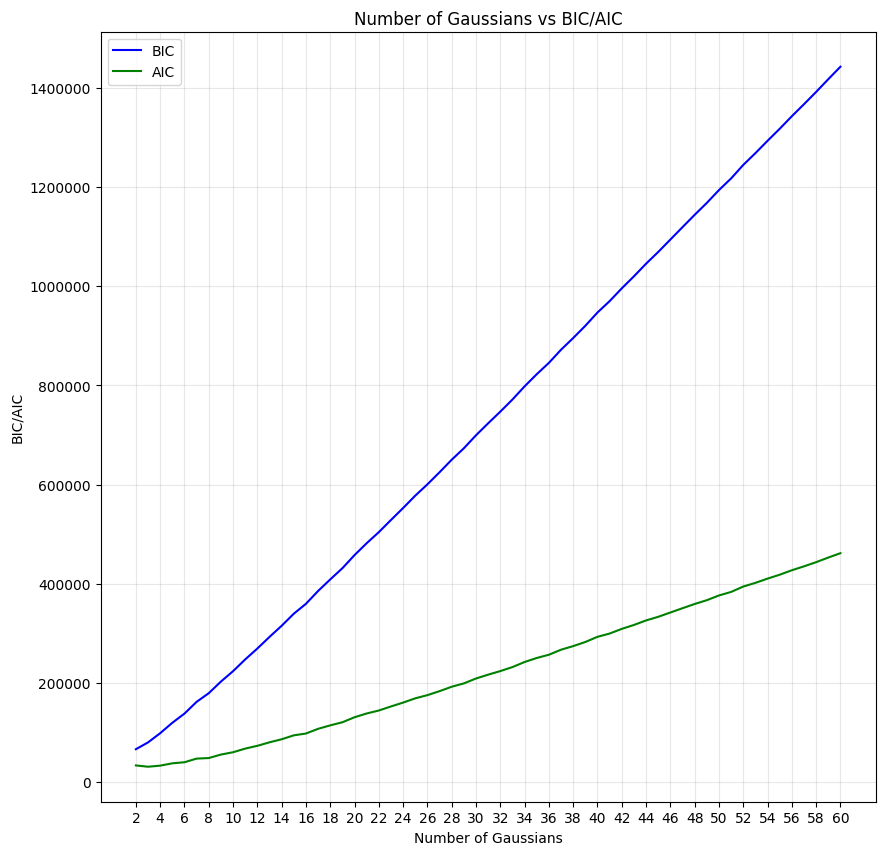

Optimal number of components (BIC): 2
Optimal number of components (AIC): 3


In [ ]:
#### GMM ####
n_components_range = range(2, 61)
BIC = np.zeros(len(n_components_range))
AIC = np.zeros(len(n_components_range))

# Investigate AIC + BIC
for i, n_components in enumerate(tqdm.tqdm(n_components_range)):
    # See http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
    gaussMix = GaussianMixture(n_components=n_components, 
                              covariance_type="full", 
                              reg_covar=0.01)
    
    # Fit once and use the same model for both metrics
    gaussMix.fit(numpy_data)
    BIC[i] = gaussMix.bic(numpy_data)
    AIC[i] = gaussMix.aic(numpy_data)

# Plotting
plt.figure(figsize=(10, 10))
plt.plot(n_components_range, BIC, c='b', label="BIC")
plt.plot(n_components_range, AIC, c='g', label="AIC")
plt.xlabel("Number of Gaussians")
plt.xticks(range(2, 61, 2))
plt.ylabel("BIC/AIC")
plt.legend()
plt.title("Number of Gaussians vs BIC/AIC")
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# Find optimal number of components
optimal_n_components_bic = n_components_range[np.argmin(BIC)]
optimal_n_components_aic = n_components_range[np.argmin(AIC)]

print(f"Optimal number of components (BIC): {optimal_n_components_bic}")
print(f"Optimal number of components (AIC): {optimal_n_components_aic}")

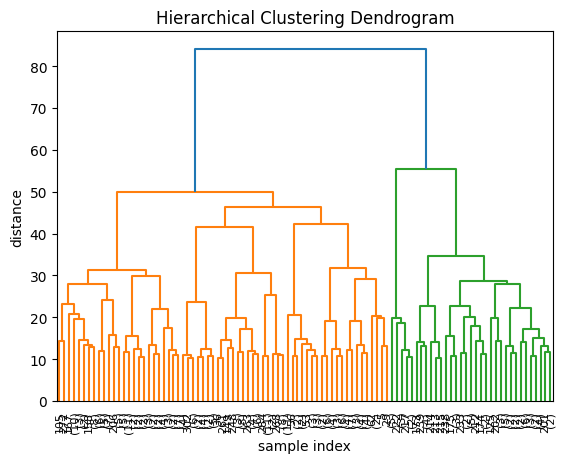

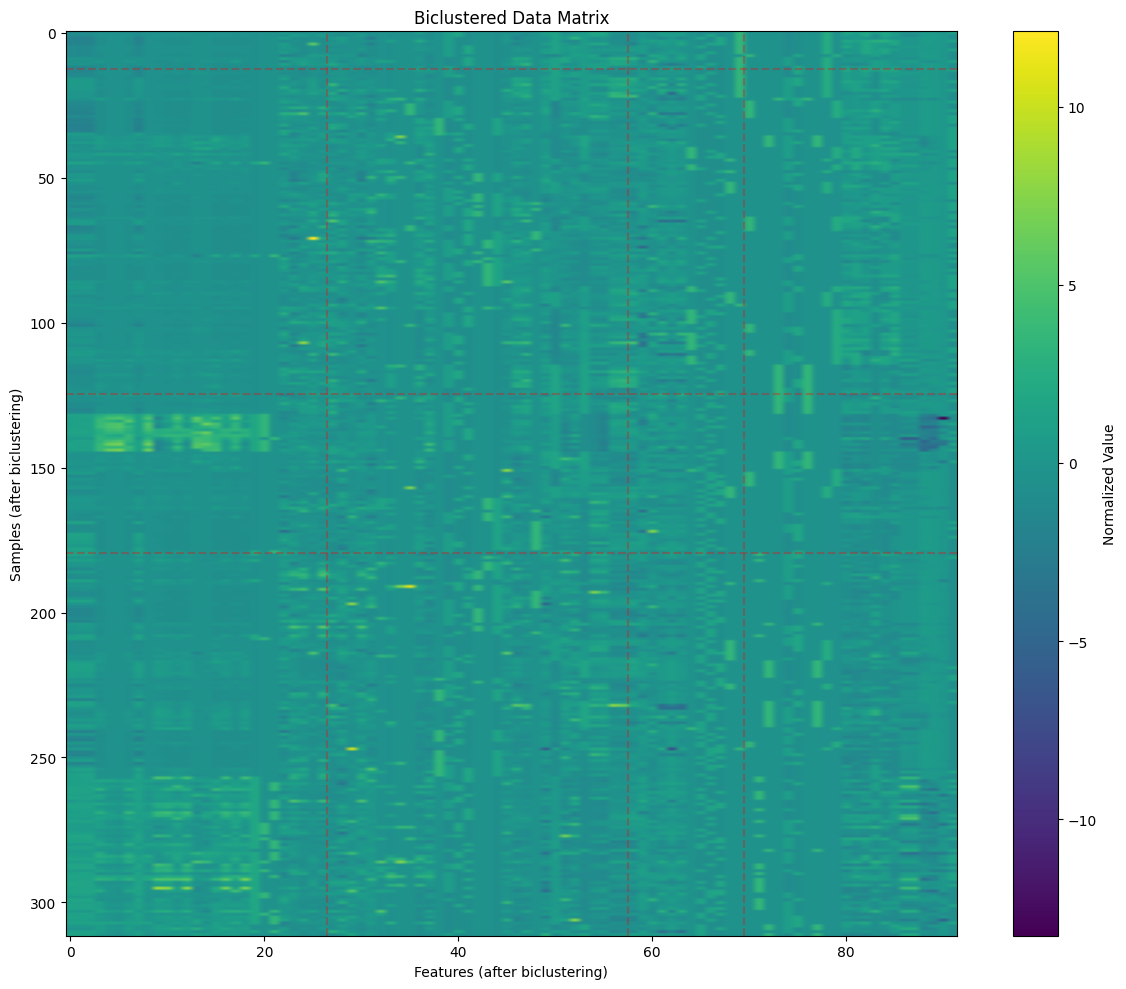

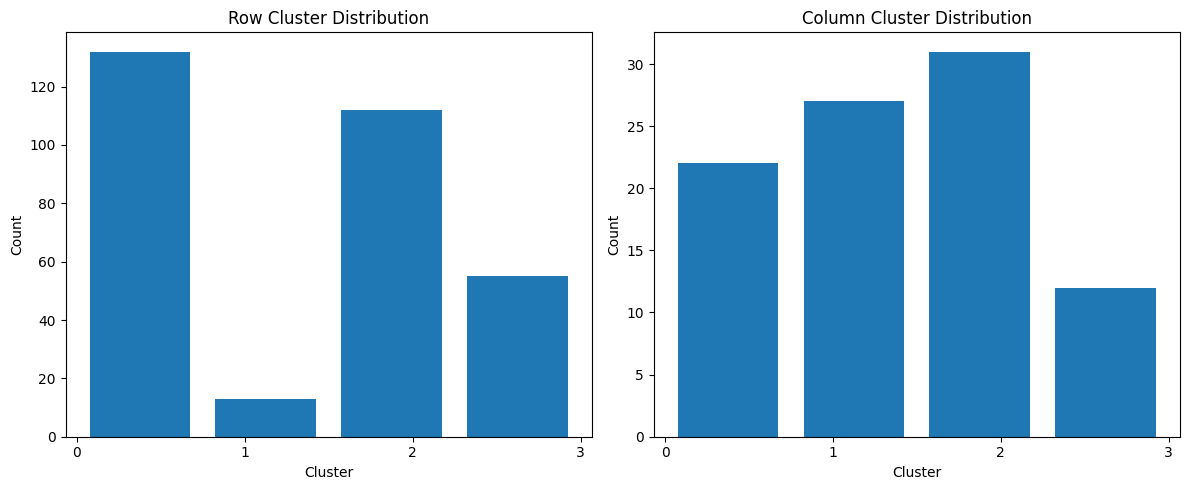

In [ ]:
#### Hierarchical clustering #### -------------- WORK IN PROGRESS --------------
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

d_sample = 'euclidean' #See possible values: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist
d_group = 'ward' #See possible values (method): https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
N_leafs = 100 #Number of leaf nodes. n=400

Z = linkage(numpy_data, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance
plt.figure()
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

#for scipy dendogram look at;
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

den = dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    p = N_leafs,
)
plt.show()


# Biclustering using Spectral Biclustering
n_clusters = (4, 4)  # Example: 4 row clusters, 4 column clusters
model = SpectralBiclustering(
    n_clusters=n_clusters,
    method='log',
    random_state=0
)

# Fit the model
model.fit(numpy_data)

# Get row and column labels
row_labels = model.row_labels_
col_labels = model.column_labels_

# Rearrange data to show biclusters
fit_data = numpy_data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

# Visualize the biclustered data
plt.figure(figsize=(12, 10))
plt.title("Biclustered Data Matrix")
im = plt.imshow(fit_data, cmap='viridis', aspect='auto')
plt.colorbar(im, label='Normalized Value')
plt.xlabel('Features (after biclustering)')
plt.ylabel('Samples (after biclustering)')

# Add lines to separate clusters
row_idx = np.cumsum(np.bincount(model.row_labels_)[1:])
col_idx = np.cumsum(np.bincount(model.column_labels_)[1:])
for i in row_idx:
    plt.axhline(i - 0.5, color='r', linestyle='--', alpha=0.3)
for i in col_idx:
    plt.axvline(i - 0.5, color='r', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize cluster assignments
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Row Cluster Distribution")
plt.hist(model.row_labels_, bins=n_clusters[0], rwidth=0.8)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(range(n_clusters[0]))

plt.subplot(1, 2, 2)
plt.title("Column Cluster Distribution")
plt.hist(model.column_labels_, bins=n_clusters[1], rwidth=0.8)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(range(n_clusters[1]))

plt.tight_layout()
plt.show()

In [102]:
# K-means — Week 1 & Week 9
# Gaussian Mixture Models (GMM) — Week 9
# Gap statistics — Week 9

# Hierarchical clustering — Week 9
# Self-Organizing Maps (SOM) — Week 10
# Spectral Clustering (SC) — Week 11
# Non-negative Matrix Factorization (NMF) — Week 11
# Archetypal Analysis (AA) — Week 11
# Independent Component Analysis (ICA) — Week 11